# Kaggle Leaf Classification Challenge


In [1]:
## Install pandas if you don't already have it (uncomment line below)

! pip install pandas matplotlib scikit-image scikit-learn

In [2]:
## If you are working on Colab, data_utils can be downloaded using the command below (uncomment line below)
# ! curl -O https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/6_Mini_Project/data_utils.py

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# Tying everything together

Now that you have learned about the most common network architectures, it is time to combine them into a more advanced model. 
It often happens that you have a combination of data that cannot easily be modeled by any single one of these types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook, we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](https://www.kaggle.com/) that contains several different kinds of data.
We will download the data, visualize it, and train a classifier.
A simple network with poor performance is provided for you as a starting point, but it is up to you use what you have learnt to improve the results.


## Kaggle challenge

Kaggle is a website to participate in real-world challenges.
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

We will undertake the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge. We report here the description of the dataset:

> The dataset consists of approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.


# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create an account
2. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
3. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch\4_Mini_Project
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Upload data to colab
If you're running this notebook on google colab, you'll need to upload `data_utils.py` that we provide as well as the data you've just downloaded from kaggle to colab. Small files like `data_utils.py` you can simply upload via the folder icon to the left. Files that are uploaded like this, however, will be deleted every time the session ends. For big files like the kaggle data folder it's therefore better to:

1. upload the data to google drive
2. mount the google drive (see cell below)

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

After going through a quick authorization process you should now have access to the uploaded file via colab. We can check the location of our data as follows:

In [5]:
#!ls drive/'My Drive'

Let's save the path for later use. Just replace this with your local path if you're not running on colab.

In [6]:
# Since I am running locally I will use the data from the folder i am in


# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [7]:
image_paths = glob.glob('images/*.jpg')
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
train_images = ['images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv('test.csv')

Total Observations:	 1584


## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint**: You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [8]:
# Getting the number of samples for training and testing
num_train_samples = train.shape[0]
num_test_samples = test.shape[0]

print(f"Number of training samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")


Number of training samples: 990
Number of test samples: 594


We have 990 samples of leaves for the training set and 594 for the test set. For each sample there is a number of features. 


In the following I will look at the supplied features:

In [9]:
# Displaying the names of the features
print("Features in the dataset:")
print(list(train.columns))


Features in the dataset:
['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6', 'margin7', 'margin8', 'margin9', 'margin10', 'margin11', 'margin12', 'margin13', 'margin14', 'margin15', 'margin16', 'margin17', 'margin18', 'margin19', 'margin20', 'margin21', 'margin22', 'margin23', 'margin24', 'margin25', 'margin26', 'margin27', 'margin28', 'margin29', 'margin30', 'margin31', 'margin32', 'margin33', 'margin34', 'margin35', 'margin36', 'margin37', 'margin38', 'margin39', 'margin40', 'margin41', 'margin42', 'margin43', 'margin44', 'margin45', 'margin46', 'margin47', 'margin48', 'margin49', 'margin50', 'margin51', 'margin52', 'margin53', 'margin54', 'margin55', 'margin56', 'margin57', 'margin58', 'margin59', 'margin60', 'margin61', 'margin62', 'margin63', 'margin64', 'shape1', 'shape2', 'shape3', 'shape4', 'shape5', 'shape6', 'shape7', 'shape8', 'shape9', 'shape10', 'shape11', 'shape12', 'shape13', 'shape14', 'shape15', 'shape16', 'shape17', 'shape18', 'shape19'

This fits the data description found on the website: 

File descriptions
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format
- images - the image files (each image is named with its corresponding id)

Data fields
- id - an anonymous id unique to an image
- margin_1, margin_2, margin_3, ..., margin_64 - each of the 64 attribute vectors for the margin feature
- shape_1, shape_2, shape_3, ..., shape_64 - each of the 64 attribute vectors for the shape feature
- texture_1, texture_2, texture_3, ..., texture_64 - each of the 64 attribute vectors for the texture feature

Now I check if there are any differences in the features between training and test set:

In [10]:
# Checking if training and test data have the same columns
columns_diff = train.columns.symmetric_difference(test.columns)

if columns_diff.empty:
    print("Training and test data have the same columns.")
else:
    print(f"Columns present in one but not the other: {columns_diff}")


Columns present in one but not the other: Index(['species'], dtype='object')


It makes sense that the training data set has the extre species feature as this it the target feature we which to identify on the test dataset 

Now I will see how each species is represented in the training dataset, meaning printing how many of each species are in the dataset. To further enhance the understanding I will also do a barplot. 

Number of samples for each species in the training set:
species
Acer_Opalus                    10
Crataegus_Monogyna             10
Acer_Mono                      10
Magnolia_Heptapeta             10
Acer_Capillipes                10
                               ..
Alnus_Rubra                    10
Rhododendron_x_Russellianum    10
Cytisus_Battandieri            10
Liriodendron_Tulipifera        10
Sorbus_Aria                    10
Name: count, Length: 99, dtype: int64


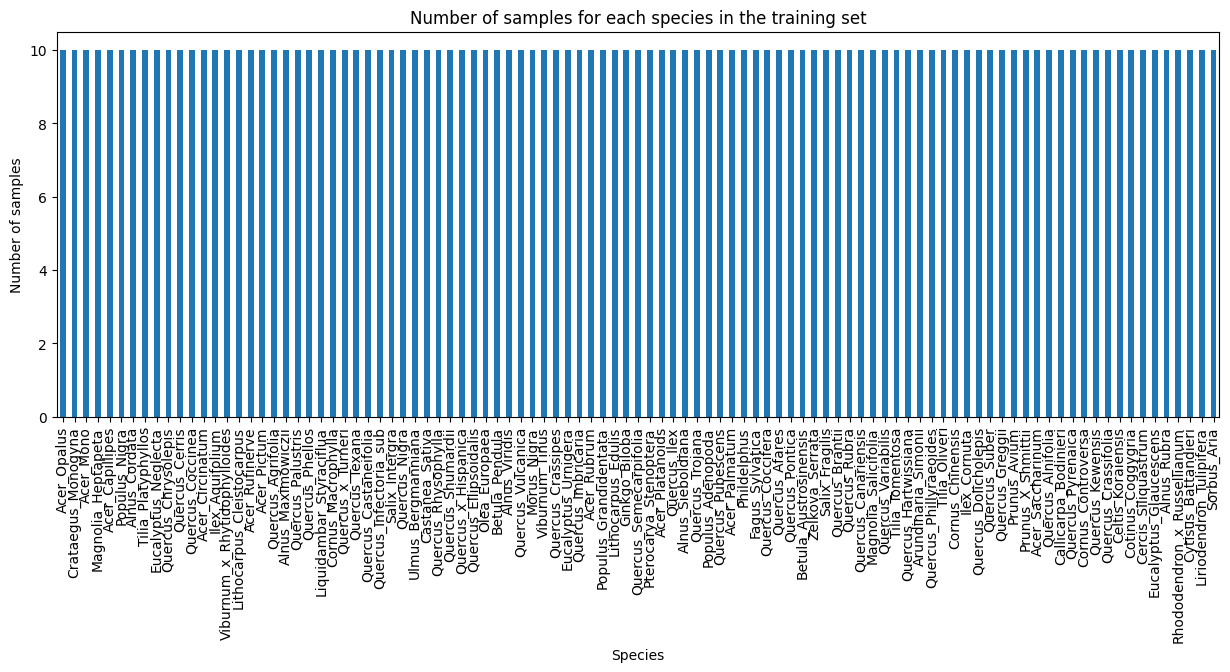

In [11]:
# Counting the number of samples for each species in the training set
species_counts = train['species'].value_counts()

print("Number of samples for each species in the training set:")
print(species_counts)

# Doing a barplot of the species counts
species_counts.plot(kind='bar', figsize=(15, 5))
plt.title("Number of samples for each species in the training set")
plt.ylabel("Number of samples")
plt.xlabel("Species")
plt.show()



I conclude that all species are equally represented in the training dataset with 10 samples each. 

With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discerns **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

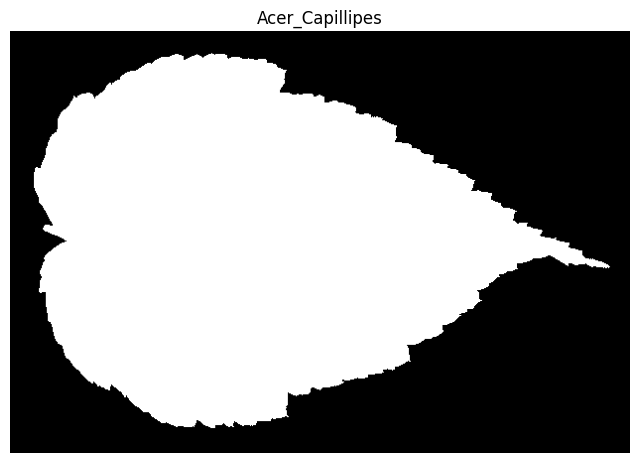

Image shape: (425, 625)


In [12]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# if on windows, replace '/' with '\\'
if os.name == 'nt':
    image_paths = [path.replace("\\", "/") for path in image_paths]


# Then we gather its index in our list of images in order to find the correct image
indexes = [image_paths.index('images/{}.jpg'.format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

# print image shape
print("Image shape:", image.shape)

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

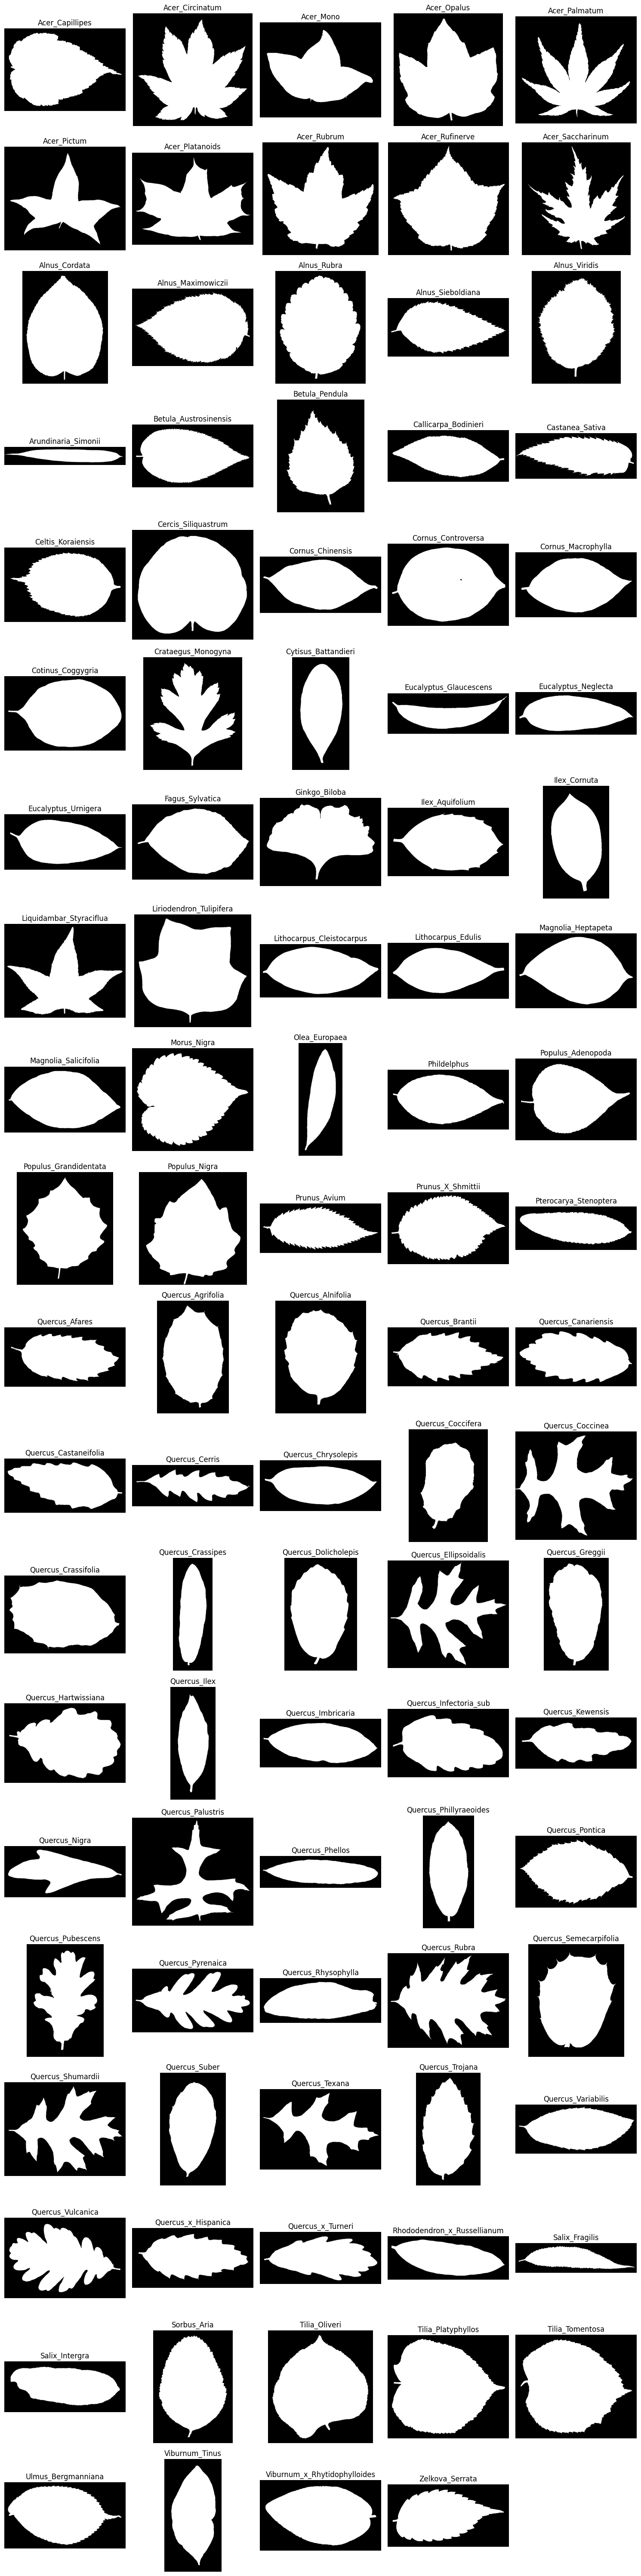

In [13]:
# Now plot 1 image from each category
# Set up the plot grid
num_species = len(species)
cols = 5  # Number of columns for the plot
rows = (num_species // cols) + 1  # Calculate required number of rows

# Create a plot
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()  # Flatten to iterate over all subplots

for i, idx in enumerate(indexes):
    # Read and plot the image
    image = imread(image_paths[idx], as_gray=True)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(species[i])
    axes[i].axis('off')  # Hide the axes for a cleaner look

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



As you can see, classifying leaves is actually a very tough problem.
What makes it even worse is that we cannot use all the image data we have available.
In order to decrease the amount of computation needed, we need to reduce the size of the images as much as possible.
On top of that, our neural network usually only accepts fixed-size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its shape into account seems extremely difficult.

Therefore we will 
1. first pad all the images into squares, and
2. then resize them.

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is too small should ultimately be determined by an actual test, but what makes sense visually is probably a good place to start.
Change the `image_size = (?, ?)` parameter below, and note your choice.
 * **Answer:**


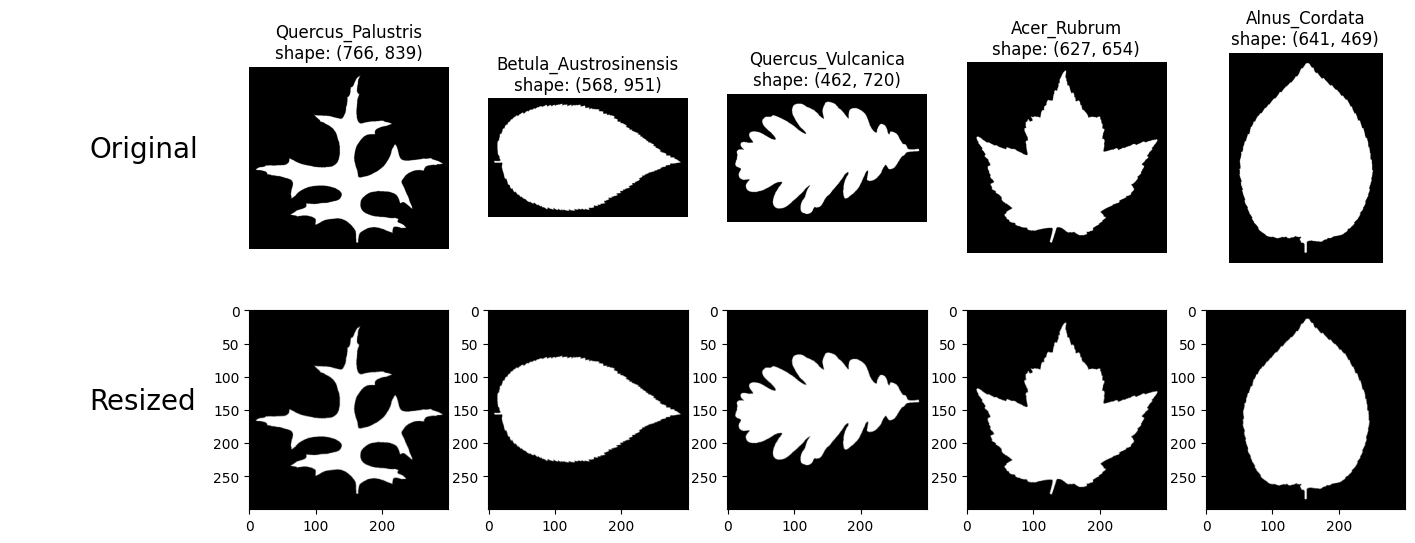

In [14]:
# Define the desired size for resizing the images (width, height)
image_size = (300, 300)  # <-- YOUR CODE HERE

# Number of images to display
amount = 5

# Randomly select 'amount' images from the list of training images
image_sample = np.random.choice(train_images, amount)

# Define the size of the entire figure (width, height in inches)
fig = plt.figure(figsize=(18, 6))

# Add a title to the first row: "Original"
ax = plt.subplot(2, amount + 1, 1)  # Create an empty subplot at position (1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)  # Add text "Original" to label the section
txt.set_clip_on(False)  # Prevent the text from being clipped by the subplot boundary
plt.axis('off')  # Hide the axes for a clean display

# Loop through the selected images to display the originals
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)  # Create a subplot for each image in the first row
    image = imread(path, as_gray=True)  # Read the image in grayscale
    plt.imshow(image, cmap='gray')  # Display the image in grayscale
    # Extract the image ID to find the corresponding species name
    _id = int(path.split('/')[-1].split('.')[0])
    # Set the title with the species name and the original image shape
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')  # Hide the axes for a clean display

# Add a title to the second row: "Resized"
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)  # Create an empty subplot at the start of the second row
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)  # Add text "Resized" to label the section
txt.set_clip_on(False)  # Prevent the text from being clipped by the subplot boundary
plt.axis('off')  # Hide the axes for a clean display

# Loop through the selected images to display the resized versions
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3  # Calculate the position for each subplot in the second row
    plt.subplot(2, amount + 1, i)  # Create a subplot for each resized image
    image = imread(path, as_gray=True)  # Read the image in grayscale
    image = data_utils.pad2square(image)  # Pad the image to make it square
    # Resize the padded image to the defined 'image_size' with anti-aliasing for quality
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)
    plt.imshow(image, cmap='gray')  # Display the resized image in grayscale

# Show the figure with both the original and resized images
plt.show()

**I Choose a image sizer of 300x300 as this seems a good middelway between reducing the number of pixels and still keeping a high enough resolution to see the small edges**

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Run it a few times to try and get an understanding of how the features differ from species to species.

In [15]:
pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [16]:
import ipywidgets as widgets
from IPython.display import display

In [17]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Set the number of images to show at a time
amount = 20

# Create scrollable widgets for each feature category
output_widgets = []

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    output = widgets.Output()  # Create an Output widget
    with output:
        # Set up a figure for each row
        fig, axes = plt.subplots(1, 4, figsize=(24, 2.5))
        
        # Display the species name
        ax = axes[0]
        ax.text(0.2, 0.5, species[idx][0], fontsize=15)
        ax.axis('off')
        if i == 0:
            ax.set_title('Species', fontsize=20)
        
        # Display the margin features
        ax = axes[1]
        ax.plot(margin[idx])
        ax.axis('off')
        if i == 0:
            ax.set_title('Margin', fontsize=20)
        
        # Display the shape features
        ax = axes[2]
        ax.plot(shape[idx])
        ax.axis('off')
        if i == 0:
            ax.set_title('Shape', fontsize=20)
        
        # Display the texture features
        ax = axes[3]
        ax.plot(texture[idx])
        ax.axis('off')
        if i == 0:
            ax.set_title('Texture', fontsize=20)
        
        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()
    
    output_widgets.append(output)

# Display all scrollable rows in a vertical box layout
scrollable_box = widgets.VBox(output_widgets, layout=widgets.Layout(max_height='600px', overflow='auto'))
display(scrollable_box)

## Exercise 4
So far we have learned about feed forward neural networks (FFNN), convolutional neural networks (CNN), recurrent neural networks (RNN), and transformers.

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?
 

### **Answer:**

For all features (`Image`, `Margin`, `Shape`, and `Texture`), I would use a **Convolutional Neural Network (CNN)** since they all have topological information that CNNs are designed to capture effectively.

1. **Image**: CNNs are particularly suited for image data because they can capture spatial patterns like edges, textures, and shapes through their convolutional layers. These layers help identify both low-level and high-level features in the images, which is crucial for classification.

2. **Margin**: The margin of the leaf contains boundary information. CNNs are very effective at detecting such contours and edges, as their filters can learn to pick up boundary patterns that differentiate one class from another.

3. **Shape**: Shape information is inherently spatial and topological. CNNs can recognize geometric patterns and outlines effectively through their hierarchical structure, where deeper layers capture more complex patterns in the data.

4. **Texture**: Texture represents fine-grained patterns on the leaf surface. CNNs can apply filters at different scales to capture detailed texture features, making them suitable for analyzing the surface structure of leaves.

While other network types (e.g., FFNNs, RNNs) could be used, they are less appropriate since they do not leverage the spatial structure of the data effectively. CNNs are specifically designed to process topological information efficiently, making them the best choice for this classification task.


# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you will work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [18]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (200, 300, 1)  # Height, width, 1 channel for grayscale images (adjust based on preprocessing choice)

# Define the number of classes (number of unique species in the dataset)
NUM_CLASSES = len(train['species'].unique())

# For all three feature types (margin, shape, and texture), define the number of features
# Assuming margin, shape, and texture have the same number of features as in the dataset
NUM_FEATURES = train.iloc[:, 2:66].shape[1]  # 64 features for each type (margin, shape, and texture)

# Print the defined variables for verification
print(f"IMAGE_SHAPE: {IMAGE_SHAPE}")
print(f"NUM_CLASSES: {NUM_CLASSES}")
print(f"NUM_FEATURES: {NUM_FEATURES}")


IMAGE_SHAPE: (200, 300, 1)
NUM_CLASSES: 99
NUM_FEATURES: 64


In [19]:
# Paths to data
TRAIN_PATH = "train.csv" 
TEST_PATH = "test.csv" 
IMAGE_PATHS = glob.glob("images/*.jpg")

# Check if data files has been stored with pickle as data.pickle
if not os.path.isfile("data.pickle"):
    print("Pickle file not found")
    print("Loading data from scratch")
    # train holds both X (input) and t (target/truth)
    data = data_utils.load_data(train_path=TRAIN_PATH, 
                                test_path=TEST_PATH,
                                image_paths=IMAGE_PATHS,
                                image_shape=IMAGE_SHAPE[:2])
    # to visualize the size of the dimensions of the data
    print("\n@@@Shape checking of data sets@@@")
    print("TRAIN")
    print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
    print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
    print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
    print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
    print("\tts\t %s" % (data.train['ts'].shape))
    print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
    print("TEST")
    print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
    print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
    print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
    print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
    print("\tids\t%s" % (data.test['ids'].shape))

    

#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time. Simply replace `drive_path` with you `local_path` if you're not using colab. 

In [20]:
import pickle

# Dump the data into a pickle file in the current working directory
if not os.path.isfile("data.pickle"):
    with open('data.pickle', 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)



In [21]:
 # Load the data from a pickle file
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

### **Answer:**

The batch size is crucial for model training as it affects memory usage, training speed, and gradient estimates:

1. **Memory**: Larger batches require more memory, potentially exceeding available resources. Smaller batches are easier to fit in memory.

2. **Training Speed**: Larger batches process more samples at once, speeding up training per epoch. However, smaller batches allow more frequent parameter updates, which can benefit convergence.

3. **Gradient Estimates**: 
   - **Large Batches**: Provide more stable gradient estimates but can lead to smoother optimization paths, sometimes trapping the model in local minima.
   - **Small Batches**: Noisier gradients, which can help escape local minima but may slow convergence.

A reasonable batch size is **64**, balancing memory, speed, and gradient stability.

```python
batch_size = 64  # Chosen for balanced performance


In [22]:
batch_size = 64
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (64, 200, 300, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

VALID
	images, (64, 200, 300, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

TEST
	images, (64, 200, 300, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ids, 64


# Build the model

In [23]:
# Load functions
! pip install torch torchvision torchaudio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [24]:
import torch

# Define Device (CUDA, MPS, CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
    print("Using GPU")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    use_cuda = True
    print("Using MPS")
else:
    device = torch.device('cpu')
    use_cuda = False
    print("Using CPU")

def get_variable(x):
    """ Converts tensors to the appropriate device (cuda, mps, or cpu). """
    if use_cuda:
        return x.to(device)
    return x

def get_numpy(x):
    """ Get numpy array for both cuda, mps, and cpu devices. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()


Using GPU


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming the IMAGE_SHAPE is already defined
height, width, channels = IMAGE_SHAPE

# Convolutional layer parameters
conv_out_channels = 32  # Number of filters in the convolutional layer
kernel_size = 3         # Size of the convolutional kernel
conv_stride = 1         # Stride for the convolution
conv_pad = 1            # Padding for the convolution to maintain image size

# Correctly calculate features_cat_size
features_cat_size = conv_out_channels * height * width + 128 + 32  # Conv output + margin + texture + GRU output

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layer
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        
        # Adding a recurrent unit (GRU)
        self.rnn_1 = nn.GRU(input_size=64, hidden_size=32, batch_first=True)  # Assuming input_size = 64 for the features
        
        # Output layer
        self.l_out = nn.Linear(in_features=features_cat_size,
                               out_features=NUM_CLASSES,
                               bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # Reshape input to fit the Conv2d layer
        x_img = x_img.view(-1, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        x_img = self.conv_1(x_img)                       # Apply Conv2d
        x_img = F.relu(x_img)                            # Apply activation function (ReLU)
        
        # Flatten the output for the final fully connected layer
        features_img = x_img.view(x_img.size(0), -1)     # Flatten to (batch_size, conv_out_channels * height * width)
        features.append(features_img)
        
        ## Use concatenated leaf features for FFNN ##
        x = torch.cat((x_margin, x_texture), dim=1)  # Concatenate margin and texture features
        features_vector = x
        features.append(features_vector)
        
        ## Use concatenated leaf features for RNN ##
        # Concatenate shape features into a sequence suitable for the GRU
        x_shape = x_shape.unsqueeze(1)  # Add sequence dimension for GRU (batch_size, seq_len=1, input_size=64)
        rnn_out, _ = self.rnn_1(x_shape)  # Apply GRU
        features_rnn = rnn_out[:, -1, :]   # Take the last time step output
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)  # Concatenate all features
        
        out['out'] = self.l_out(features_final)  # Pass through the final linear layer
        return out

net = Net()
net.to(device)  # Move network to device (GPU/CPU)


Net(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rnn_1): GRU(64, 32, batch_first=True)
  (l_out): Linear(in_features=1920160, out_features=99, bias=False)
)

# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [26]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()  # <-- Your code here.   

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [27]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

tensor([[ 0.0885, -0.0839, -0.2134,  ..., -0.4832, -0.0123, -0.0756],
        [ 0.3718,  0.2076, -0.2624,  ..., -0.3235, -0.0667, -0.4145],
        [ 0.2254, -0.2933,  0.1324,  ..., -0.7535,  0.0583,  0.2572],
        ...,
        [ 0.0042, -0.1407, -0.0494,  ..., -0.3350,  0.1097,  0.2046],
        [ 0.0879,  0.0728, -0.0755,  ...,  0.0464, -0.1909,  0.1916],
        [ 0.1310, -0.4457,  0.3955,  ..., -0.5218, -0.0503, -0.3115]],
       device='cuda:0', grad_fn=<MmBackward0>)

# Train

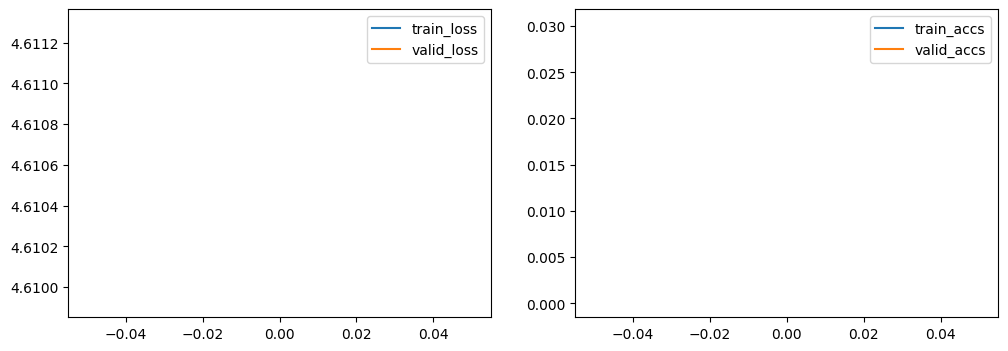

Train, it: 0 loss: 4.61 accs: 0.00


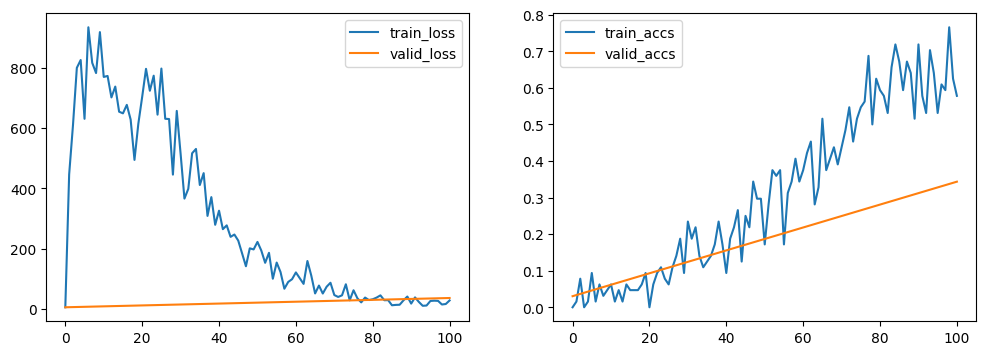

Train, it: 100 loss: 27.37 accs: 0.58


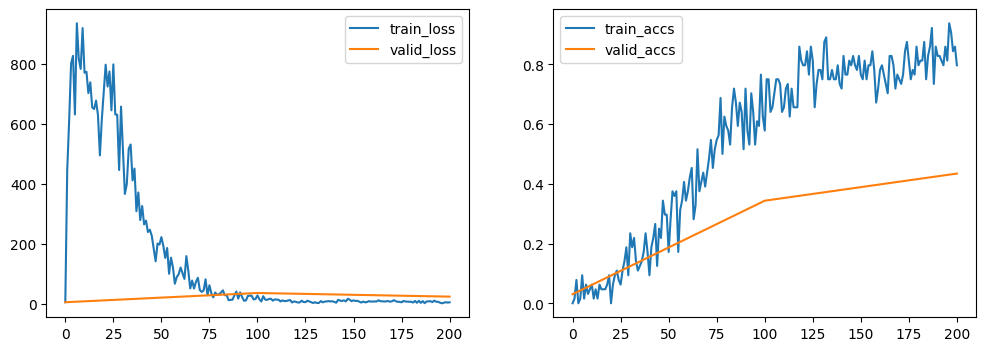

Train, it: 200 loss: 4.37 accs: 0.80


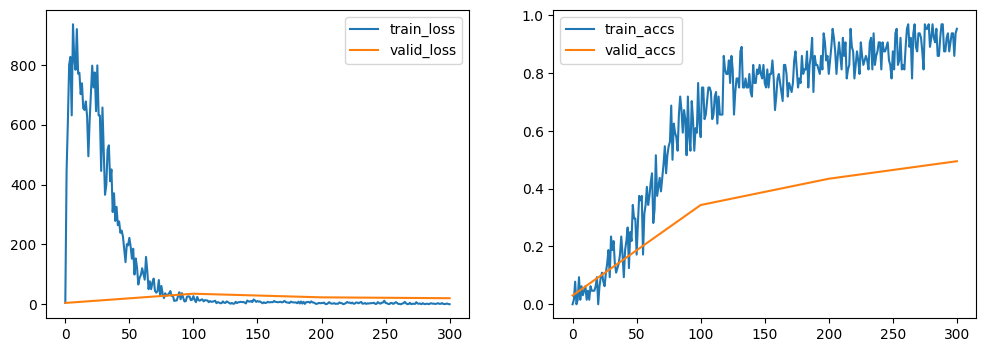

Train, it: 300 loss: 0.26 accs: 0.95


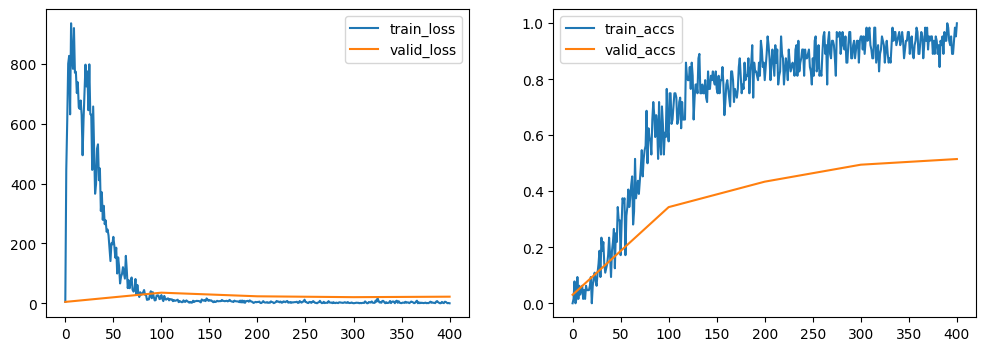

Train, it: 400 loss: 0.00 accs: 1.00


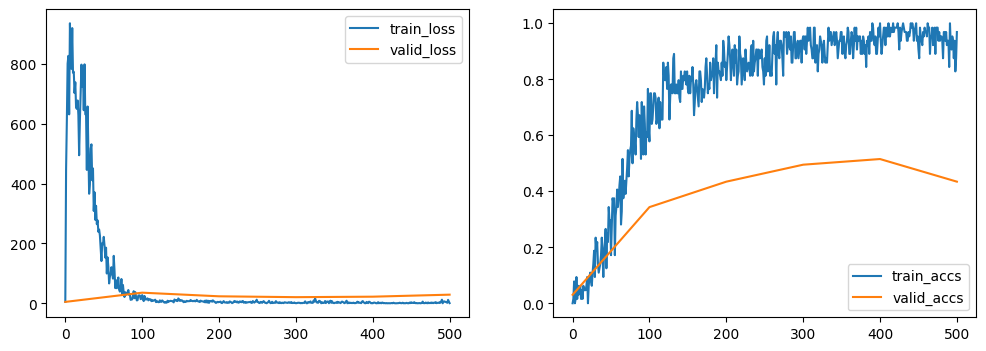

Train, it: 500 loss: 0.57 accs: 0.97


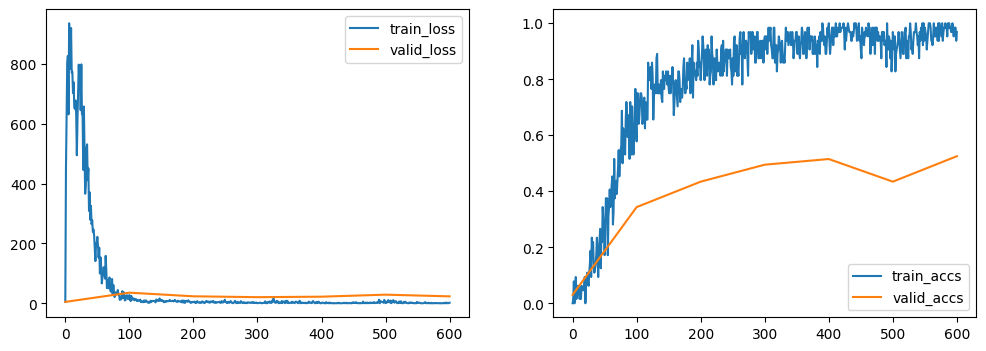

Train, it: 600 loss: 1.86 accs: 0.97


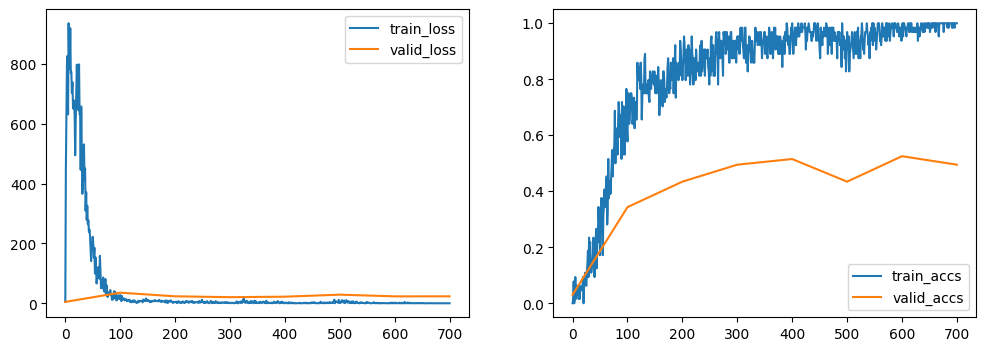

Train, it: 700 loss: 0.00 accs: 1.00


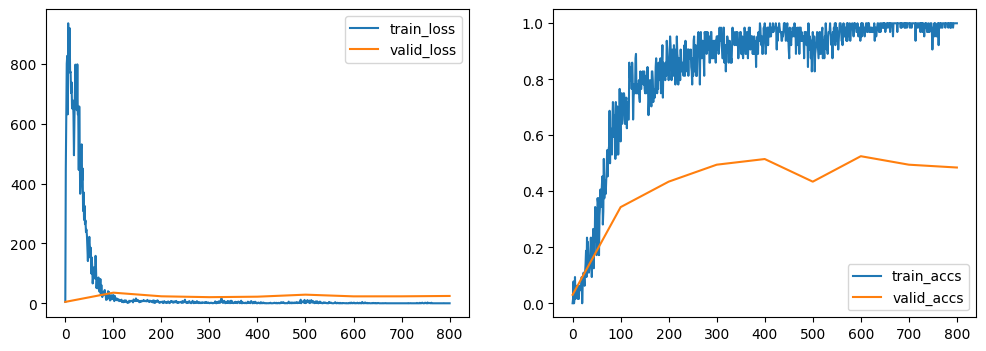

Train, it: 800 loss: 0.00 accs: 1.00


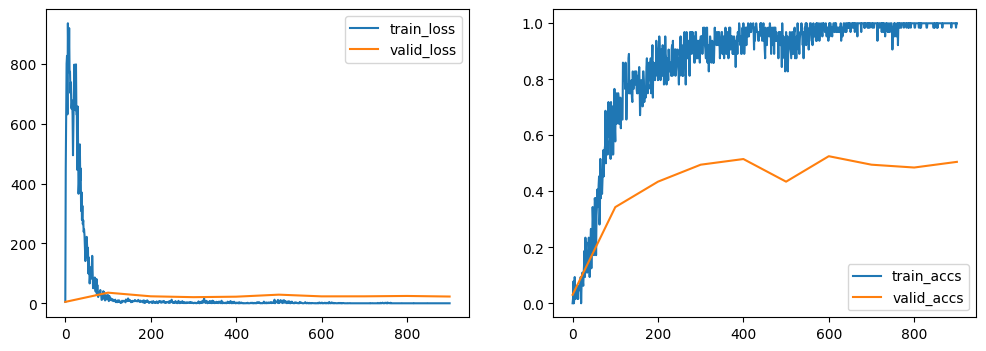

Train, it: 900 loss: 0.00 accs: 1.00


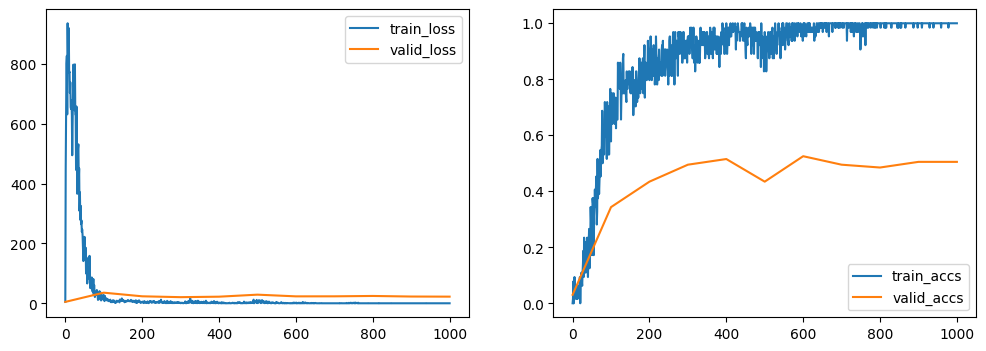

Train, it: 1000 loss: 0.00 accs: 1.00


In [28]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 1000
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

This networks shows clear signs of overfitting as the training accuracy hits the 100% accuracy ceiling while the validation accuracy remains low at around 0.56. 

## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**9.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**9.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 


**9.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture
* Description of the training parameters
* Description of the final results (Kaggle and validation)

**Answer:**


Before I proceed with this section I will make helper functions for training

In [29]:

def train_network(net, data, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=100, eval_every=100, validation_size=0.1):
    # Function to get label
    def get_labels(batch):
        return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

    # Function to get input
    def get_input(batch):
        return {
            'x_img': get_variable(Variable(torch.from_numpy(batch['images']).permute(0, 3, 1, 2))),  # Ensure correct shape
            'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
            'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
            'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
        }

    
    # Initialize lists for tracking training and validation metrics
    train_iter, train_loss, train_accs = [], [], []
    valid_iter, valid_loss, valid_accs = [], [], []

    # Generate batches
    batch_gen = data_utils.batch_generator(
        data,
        batch_size=batch_size,
        num_classes=NUM_CLASSES,
        num_iterations=max_iter,
        seed=42,
        val_size=validation_size
    )

    # Training loop
    net.train()
    for i, batch_train in enumerate(batch_gen.gen_train()):
        # Validation step
        if i % eval_every == 0:
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            for batch_valid, num in batch_gen.gen_valid():
                output = net(**get_input(batch_valid))
                labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                val_losses += criterion(output['out'], labels_argmax) * num
                val_accs += accuracy(output['out'], labels_argmax) * num
                val_lengths += num

            # Calculate averages
            val_losses /= val_lengths
            val_accs /= val_lengths
            valid_loss.append(get_numpy(val_losses))
            valid_accs.append(get_numpy(val_accs))
            valid_iter.append(i)
            net.train()
        
        # Training step
        output = net(**get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]
        batch_loss = criterion(output['out'], labels_argmax)

        # Store training metrics
        train_iter.append(i)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        # Backpropagation
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        # Logging
        if i % log_every == 0:
            fig = plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')
            plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='train_accs')
            plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.show()
            # Print training loss and accuracy
            print(f"Train, it: {i} loss: {train_loss[-1]:.2f} accs: {train_accs[-1]:.2f}")
            # print validation loss and accuracy
            print(f"Valid, it: {i} loss: {valid_loss[-1]:.2f} accs: {valid_accs[-1]:.2f}\n")
        
        # Early stopping condition
        if i >= max_iter:
            break

    # Return the metrics for further analysis if needed
    return {
        'train_iter': train_iter,
        'train_loss': train_loss,
        'train_accs': train_accs,
        'valid_iter': valid_iter,
        'valid_loss': valid_loss,
        'valid_accs': valid_accs
    }


In [30]:
# Also make a initialize network function
def initialize_network():
    net = Net()
    # Define Device (CUDA, MPS, CPU)
    if torch.cuda.is_available():
        device = torch.device('cuda')
        use_cuda = True
        print("Using GPU")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        use_cuda = True
        print("Using MPS")
    else:
        device = torch.device('cpu')
        use_cuda = False
        print("Using CPU")

    net.to(device)
    return net

In [31]:
import gc

def clear_memory():
    # Delete model, optimizer, and any large variables
    global net, optimizer, criterion, batch_gen
    del net, optimizer, criterion, batch_gen

    # Clear up Python garbage collection
    gc.collect()

    # If using GPU, clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()



In [32]:
# Data loading and preprocessing functions
def dataloader(train_path="train.csv", test_path="test.csv", image_dir="images", pickle_file="data.pickle", image_shape=None):
    # Get all image paths
    image_paths = glob.glob(f"{image_dir}/*.jpg")
    
    # Check if pickle file exists
    if os.path.isfile(pickle_file):
        print(f"Loading data from {pickle_file}")
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f"{pickle_file} not found")
        print("Loading data from scratch using data_utils")

        # Load data using data_utils
        data = data_utils.load_data(train_path=train_path, 
                                    test_path=test_path,
                                    image_paths=image_paths,
                                    image_shape=image_shape[:2] if image_shape else None)

        # Print shape and statistics of data for visualization
        print("\n@@@ Shape checking of data sets @@@")
        print("TRAIN")
        print("\timages\t%s\t%f" % (data.train['images'].shape, data.train['images'].mean()))
        print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
        print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
        print("\ttextures\t%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
        print("\tts\t%s" % (data.train['ts'].shape))
        print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
        print("TEST")
        print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
        print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
        print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
        print("\ttextures\t%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
        print("\tids\t%s" % (data.test['ids'].shape))

        # Save the data to a pickle file
        with open(pickle_file, 'wb') as f:
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
            print(f"Data saved to {pickle_file}")
    
    return data



## Exercise 9.1


I first want to make the Network more complex to better capture the information in the features available. 

In [74]:
# Clear cuda memory
if net:
    clear_memory()
torch.cuda.empty_cache()

In [108]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv_1 = nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Calculate the output size after convolutions and pooling
        conv_out_height = height // (2 * 2 * 2)  # Adjust for pooling layers
        conv_out_width = width // (2 * 2 * 2)
        conv_out_features = 128 * conv_out_height * conv_out_width
        
        # Fully connected layer (updated in_features)
        self.fc1 = nn.Linear(in_features=conv_out_features + 128 + 32, out_features=256)
        
        # GRU
        self.rnn_1 = nn.GRU(input_size=64, hidden_size=32, batch_first=True)
        
        # Output layer
        self.l_out = nn.Linear(in_features=256, out_features=NUM_CLASSES)

    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []

        # Convolutional layers with pooling
        x_img = self.pool(F.relu(self.conv_1(x_img)))
        x_img = self.pool(F.relu(self.conv_2(x_img)))
        x_img = self.pool(F.relu(self.conv_3(x_img)))
        print(f"Convolution output shape: {x_img.shape}")

        # Flatten the output from convolutions
        features_img = x_img.reshape(x_img.size(0), -1)
        print(f"Flattened image features shape: {features_img.shape}")
        features.append(features_img)

        # Concatenate margin and texture features
        features_vector = torch.cat((x_margin, x_texture), dim=1)
        print(f"Concatenated margin and texture features shape: {features_vector.shape}")
        features.append(features_vector)

        # RNN for shape features
        x_shape = x_shape.unsqueeze(1)
        rnn_out, _ = self.rnn_1(x_shape)
        features_rnn = rnn_out[:, -1, :]
        print(f"RNN output shape: {features_rnn.shape}")
        features.append(features_rnn)

        # Concatenate all features
        features_final = torch.cat(features, dim=1)
        print(f"Final concatenated features shape: {features_final.shape}")

        # Fully connected layer
        x = F.relu(self.fc1(features_final))
        
        # Output layer
        out = self.l_out(x)

        return {'out': out}


### Explanation of Changes

- **Additional Convolutional Layers**: Added `conv_2` and `conv_3`, which use 64 and 128 filters, respectively. Each layer is followed by a ReLU activation to introduce non-linearity.

- **Calculate New Feature Size**: Updated the feature size (`conv_out_features`) to reflect the output of the last convolutional layer, calculated as `128 * height * width`.

- **New Fully Connected Layer (`fc1`)**: Introduced a fully connected layer (`fc1`) that processes the concatenated features before passing them to the final output layer.

- **Updated Output Layer**: The `l_out` layer now takes the output of `fc1` as input with an adjusted feature size.


In [109]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (200, 300, 1)  # Height, width, 1 channel for grayscale images (adjust based on preprocessing choice)

# Define the number of classes (number of unique species in the dataset)
NUM_CLASSES = len(train['species'].unique())

# For all three feature types (margin, shape, and texture), define the number of features
# Assuming margin, shape, and texture have the same number of features as in the dataset
NUM_FEATURES = train.iloc[:, 2:66].shape[1]  # 64 features for each type (margin, shape, and texture)

# Print the defined variables for verification
print(f"IMAGE_SHAPE: {IMAGE_SHAPE}")
print(f"NUM_CLASSES: {NUM_CLASSES}")
print(f"NUM_FEATURES: {NUM_FEATURES}")


IMAGE_SHAPE: (200, 300, 1)
NUM_CLASSES: 99
NUM_FEATURES: 64


I call the network

In [110]:
# init the new network
# Remove the old network to free up memory
net = initialize_network()

Using GPU


In [111]:
# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Training the more complex network

In [112]:
# train the new network
train_results = train_network(net, data, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=100, eval_every=100, validation_size=0.1)

Convolution output shape: torch.Size([64, 128, 25, 37])
Flattened image features shape: torch.Size([64, 118400])
Concatenated margin and texture features shape: torch.Size([64, 128])
RNN output shape: torch.Size([64, 32])
Final concatenated features shape: torch.Size([64, 118560])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x118560 and 27808x256)

My previous network showed  clear signs of overfitting. Therefore I will proceed to implement some regularization. 

I first try by adding some L2-Regularization

I do this by adding weight decay in the optimizer

I call the training function

# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get our score! You can upload up to 5 submissions per day.

In [ ]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = output['out'].data

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

## Make submission file

In [ ]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv(drive_path + 'submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 